# Support Vector Machines (SVM)

Support vector machines (SVMs) are a particularly powerful and flexible class of supervised algorithms for both classification and regression. In this section, we will develop the intuition behind support vector machines and their use in classification problems.

You can first execute this tutorial by following each step. You're then invited to tweak the function parameters to see what your changes do, and in particular whether they improve or decrease the algorithm's performance (or simply don't work).

Let's get started.

In [1]:
# Allow to show plots in the notebook
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns
sns.set()

Let's position some random points (50) around two centers using [Scikit-Learn](https://scikit-learn.org/)'s `sklearn.datasets.make_blobs` function and plot the output with Matplotlib.


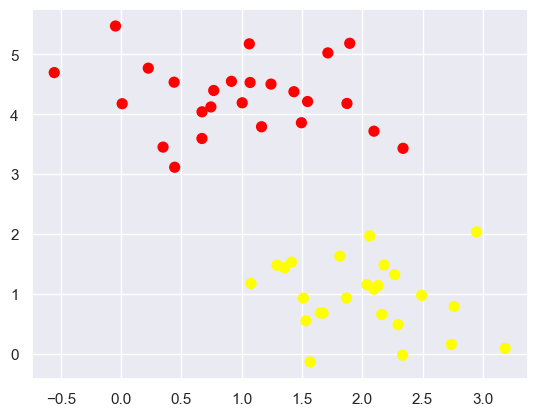

In [2]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');
#print(X, y)

A linear discriminative classifier will attempt to draw a straight line separating the two sets of data, and thereby create a model for classification.

For two dimensional data like that shown here, this is a task we could do by hand. But there is more than one possible dividing line that can perfectly discriminate between the two classes!


[-1.         -0.90816327 -0.81632653 -0.7244898  -0.63265306 -0.54081633
 -0.44897959 -0.35714286 -0.26530612 -0.17346939 -0.08163265  0.01020408
  0.10204082  0.19387755  0.28571429  0.37755102  0.46938776  0.56122449
  0.65306122  0.74489796  0.83673469  0.92857143  1.02040816  1.1122449
  1.20408163  1.29591837  1.3877551   1.47959184  1.57142857  1.66326531
  1.75510204  1.84693878  1.93877551  2.03061224  2.12244898  2.21428571
  2.30612245  2.39795918  2.48979592  2.58163265  2.67346939  2.76530612
  2.85714286  2.94897959  3.04081633  3.13265306  3.2244898   3.31632653
  3.40816327  3.5       ]
50


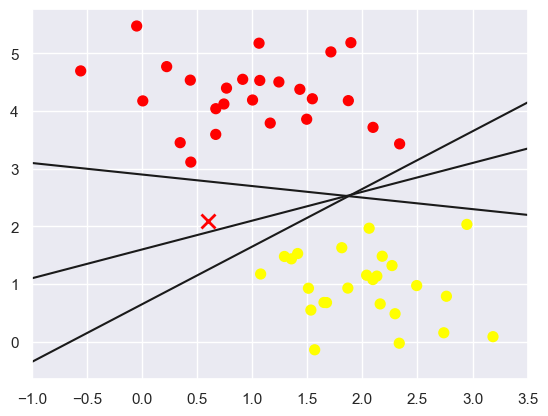

In [3]:
xfit = np.linspace(-1, 3.5)
print(xfit)
print(len(xfit))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

# Plotting y = m * x + b
for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

These are three very different separators which, nevertheless, perfectly discriminate between these samples.

Depending on which you choose, a new data point (e.g., the one marked by the `x` in this plot) will be assigned a different label. Clearly, "drawing a line between classes" is not enough.



Support vector machines offer one way to improve.

The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a margin of some width, up to the nearest point.

In SVMs, **the line that maximizes this margin is the one we will choose as the optimal model**. SVMs are an example of such a maximum margin estimator.



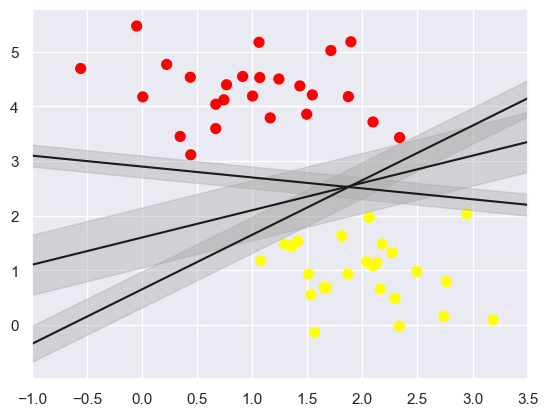

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

## Fitting SVM to data

Let's see the result of an actual fit to this data: we will use Scikit-Learn's support vector classifier to train an SVM model on this data.

For the time being, we will use a linear kernel and set the `C` parameter to a very large number (this hyper-parameter relates to softening the margnins).

In [5]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10, verbose=True)
model.fit(X, y)

[LibSVM]*
optimization finished, #iter = 8
obj = -1.025386, rho = 3.296342
nSV = 3, nBSV = 0
Total nSV = 3


SVC(C=10000000000.0, kernel='linear', verbose=True)

The function below helps us plot the SVM decision boundary.

(900, 2) (30, 30)


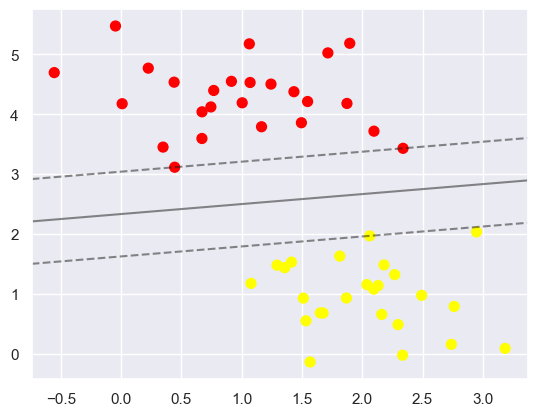

In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    print(xy.shape, X.shape)
    P = model.decision_function(xy).reshape(X.shape)

    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=5, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

This is the dividing line that maximizes the margin between the two sets of points. Notice that a few of the training points just touch the margin: they are indicated by the black circles in this figure. These points are the pivotal elements of this fit, and are known as the support vectors, and give the algorithm its name. In Scikit-Learn, the identity of these points are stored in the `support_vectors_` attribute of the classifier:

In [7]:
model.support_vectors_


array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

**Model robustness**

A key to this classifier's success is that for the fit, *only the position of the support vectors matter*; any points further from the margin which are on the correct side do not modify the fit! Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

We can see this, for example, if we plot the model learned from the first 60 points and first 120 points of this dataset:

(900, 2) (30, 30)
(900, 2) (30, 30)


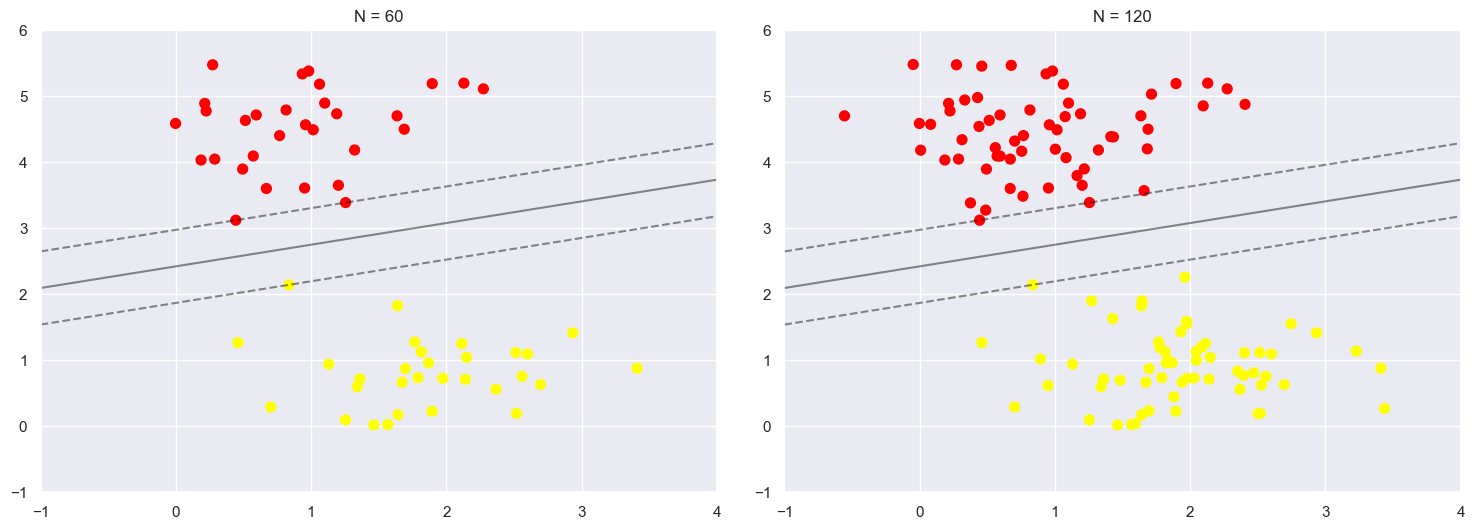

In [8]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)

    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

In interactive mode, one can probe the model with different arguments.

In [9]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 100, 200], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(10, 100, 200), value=10), Output()), _dom_classes=('w…

## Beyond linear boundaries: Kernel SVM

Where SVM becomes extremely powerful is when it is combined with kernels.



(900, 2) (30, 30)


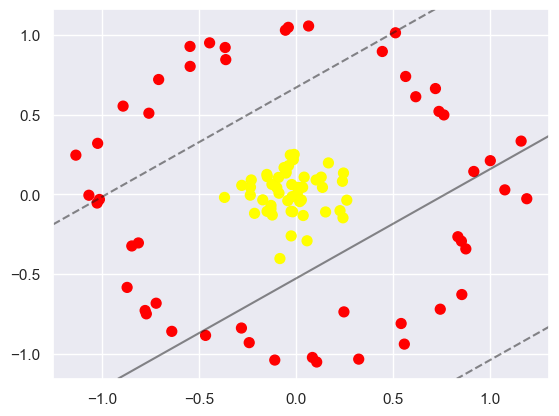

In [10]:
from sklearn.datasets import make_circles
X1, y1 = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X1, y1)

plt.scatter(X1[:, 0], X1[:, 1], c=y1, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

Using a *radial basis function*


In [11]:
r = np.exp(-(X1 ** 2).sum(1))

Looking at it in three dimensions

In [12]:
from ipywidgets import interact, fixed
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    f = plt.figure(figsize=(10,8))
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X1[:, 0], X1[:, 1], r, c=y1, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[50, 0, -50], azip=(-180, 180),
         X=fixed(X1), y=fixed(y1));

interactive(children=(Dropdown(description='elev', options=(50, 0, -50), value=50), IntSlider(value=30, descri…

In [13]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X1, y1)

SVC(C=1000000.0)

(900, 2) (30, 30)


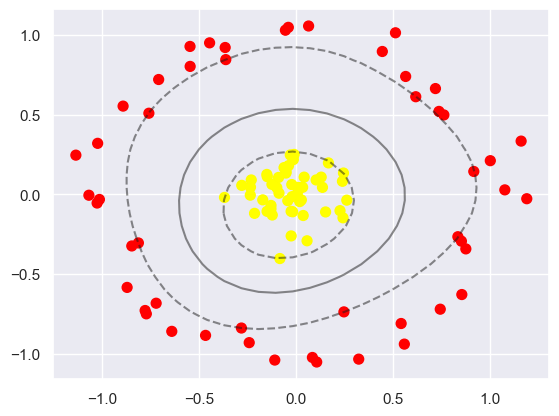

In [14]:
plt.scatter(X1[:, 0], X1[:, 1], c=y1, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

# Face Recognition with SVM

Let's take a look at how SVM handles a facial recognition problem. We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures.

Note: you might need to run this multiple times in case of timeout.

In [15]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Let's see who we are dealing with...


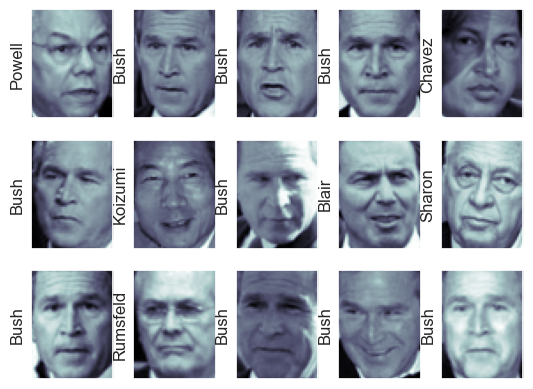

In [16]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            ylabel=faces.target_names[faces.target[i]].split()[-1])

Each image contains `[62×47]` or nearly 3,000 pixels.

We could proceed by simply using each pixel value as a feature, and we will do so when using Deep Neural Networks (DNN), but often it is more effective to use some sort of preprocessor to extract more meaningful features; here we will use a principal component analysis (PCA) to extract 150 fundamental components to feed into our support vector machine classifier.

In [17]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
modelF = make_pipeline(pca, svc)

Let's split our images into our training and testing datasets.

In [18]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

We can use a grid search cross-validation to explore combinations of parameters.

Here we will adjust C (which controls the margin hardness) and gamma (which controls the size of the radial basis function kernel), and determine the best model:


In [19]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(modelF, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 57.8 s, sys: 29 s, total: 1min 26s
Wall time: 33 s
{'svc__C': 5, 'svc__gamma': 0.001}


The optimal values fall toward the middle of our grid; if they fell at the edges, we would want to expand the grid to make sure we have found the true optimum.

Now with this cross-validated model, we can predict the labels for the test data, which the model has not yet seen.


In [20]:
modelF = grid.best_estimator_
yfit = modelF.predict(Xtest)

Let's take a look at how our model performs.


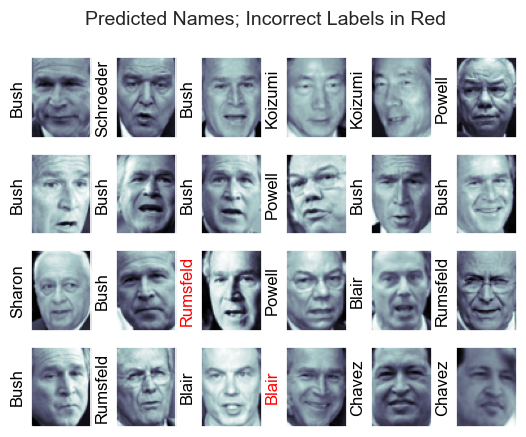

In [21]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

We can get a better sense of our estimator's performance using the classification report, which lists recovery statistics label by label.


In [22]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.87      0.74        15
     Colin Powell       0.83      0.88      0.86        68
  Donald Rumsfeld       0.70      0.84      0.76        31
    George W Bush       0.97      0.80      0.88       126
Gerhard Schroeder       0.76      0.83      0.79        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.86      1.00      0.92        12
       Tony Blair       0.82      0.98      0.89        42

         accuracy                           0.85       337
        macro avg       0.82      0.86      0.83       337
     weighted avg       0.86      0.85      0.85       337



Or we can take a look at the confusion matrix.

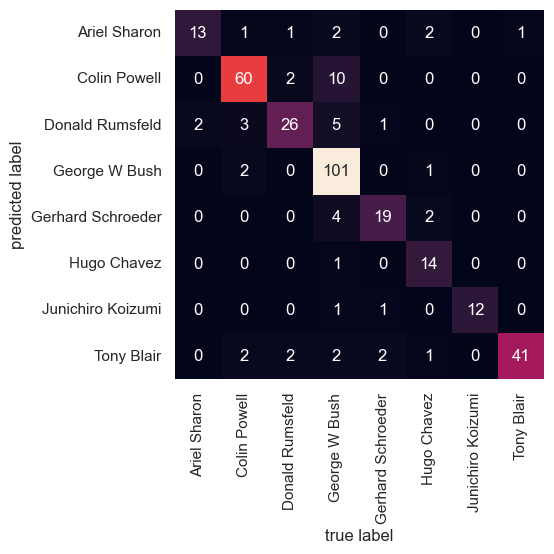

In [23]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

For a real-world facial recognition task, in which the photos do not come pre-cropped into nice grids, the only difference in the facial classification scheme is the feature selection: you would need to use a more sophisticated algorithm to find the faces, and extract features that are independent of the pixellation.